In [1]:
import pandas as pd
import numpy as np

## Data importation and understanding

**Read the .csv files in local:**

In [2]:
# Read the data in local
movies_df = pd.read_csv('ml-latest-small/movies.csv', sep=',', names=['item_id', 'title', 'genres'], engine='python',skiprows=1)
tags_df = pd.read_csv('ml-latest-small/tags.csv', sep=',', names=['user_id', 'item_id', 'tag', 'timestamp'], engine='python',skiprows=1)
ratings_df = pd.read_csv('ml-latest-small/ratings.csv', sep=',', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python',skiprows=1)

**Read the data from SQL Database:**

In [3]:
# Import the data from sql database
import pypyodbc as odbc

def connectToDatabase():
    connection_string = 'Driver={ODBC Driver 18 for SQL Server};Server=tcp:agiledsproject.database.windows.net,1433;Database=MovieRatings;Uid=ProjectDataBase;Pwd=Agile2023;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
    global conn 
    conn = odbc.connect(connection_string)
    global cursor 
    cursor = conn.cursor()
    
def get_table(tableName):
   cursor.execute(f"SELECT * FROM {tableName}")
    #data will be a list of tuples
   data = cursor.fetchall()
   # These part of the code transforms it in a dataframe
   column_names = [description[0] for description in cursor.description]
   # Create a DataFrame using fetched rows and column names
   data = pd.DataFrame(data, columns=column_names)
   return data
    
connectToDatabase()

movies_df = get_table('movies')
tags_df = get_table('tags')
ratings_df = get_table('ratings')

Error: ('IM002', '[IM002] [Microsoft][Driver Manager ODBC] Nome origine dati non trovato e driver predefinito non specificato.')

The MovieLens dataset is a widely-used dataset for movie recommendation systems, collected by the GroupLens research group at the University of Minnesota. It consists of multiple tables containing data about movies, ratings, and tags provided by users. Here’s a description of each table and its variables:

### movies_df
- **item_id**: Unique identifier for movies.
- **title**: The title of the movie, typically containing the release year in parentheses.
- **genres**: A pipe-separated list of genres associated with the movie.

This DataFrame contains metadata about the movies. Each movie is identified by a unique ID and has associated attributes like the title and the list of genres it belongs to. The genres are categorical and are typically used to filter or describe the content of the movie.

In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_id  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


### tags_df
- **user_id**: Unique identifier for users.
- **item_id**: Unique identifier for movies which corresponds to `item_id` in `movies_df`.
- **tag**: Textual tag provided by the user for a movie. These can be descriptive words or short phrases.
- **timestamp**: The timestamp when the tag was provided. This is typically a Unix time stamp and indicates when the user tagged the movie.

The `tags_df` table contains user-generated metadata for the movies. Each row indicates that a particular user has tagged a movie with a textual descriptor. These tags can be used for content-based filtering or to enhance the information about a movie beyond its genres.

In [5]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    3683 non-null   int64 
 1   item_id    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


### ratings_df
- **user_id**: Unique identifier for users, which corresponds to `user_id` in `tags_df`.
- **item_id**: Unique identifier for movies, consistent with `item_id` in both `movies_df` and `tags_df`.
- **rating**: The rating given to a movie by a user. This is typically on a defined scale, like 0.5 to 5 stars.
- **timestamp**: The timestamp when the rating was provided, in the same format as in `tags_df`.

The `ratings_df` table is a record of user ratings for movies. Each row documents that a user has assigned a numerical rating to a movie. This is the core data used in collaborative filtering for recommendation systems.

In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    100836 non-null  int64  
 1   item_id    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


When using these tables for building a recommendation system, one usually starts with the `ratings_df` to build the utility matrix that relates users to movies through the ratings they've provided. `movies_df` can be used to provide readable movie titles and genres for recommendations, and `tags_df` can add additional context for the movies or for more sophisticated recommendation systems that also use content-based filtering methods.

## Exploring the data

In [7]:
# For movies_df to count unique movies
unique_movies = movies_df['item_id'].nunique()
print(f'Unique movies: {unique_movies}')

# For ratings_df to count unique users and movies
unique_users_ratings = ratings_df['user_id'].nunique()
unique_movies_ratings = ratings_df['item_id'].nunique()
print(f'Unique users in ratings: {unique_users_ratings}')
print(f'Unique movies in ratings: {unique_movies_ratings}')

# For tags_df to count unique users, movies, and tags
unique_users_tags = tags_df['user_id'].nunique()
unique_movies_tags = tags_df['item_id'].nunique()
unique_tags = tags_df['tag'].nunique()
print(f'Unique users in tags: {unique_users_tags}')
print(f'Unique movies in tags: {unique_movies_tags}')
print(f'Unique tags: {unique_tags}')

Unique movies: 9742
Unique users in ratings: 610
Unique movies in ratings: 9724
Unique users in tags: 58
Unique movies in tags: 1572
Unique tags: 1589


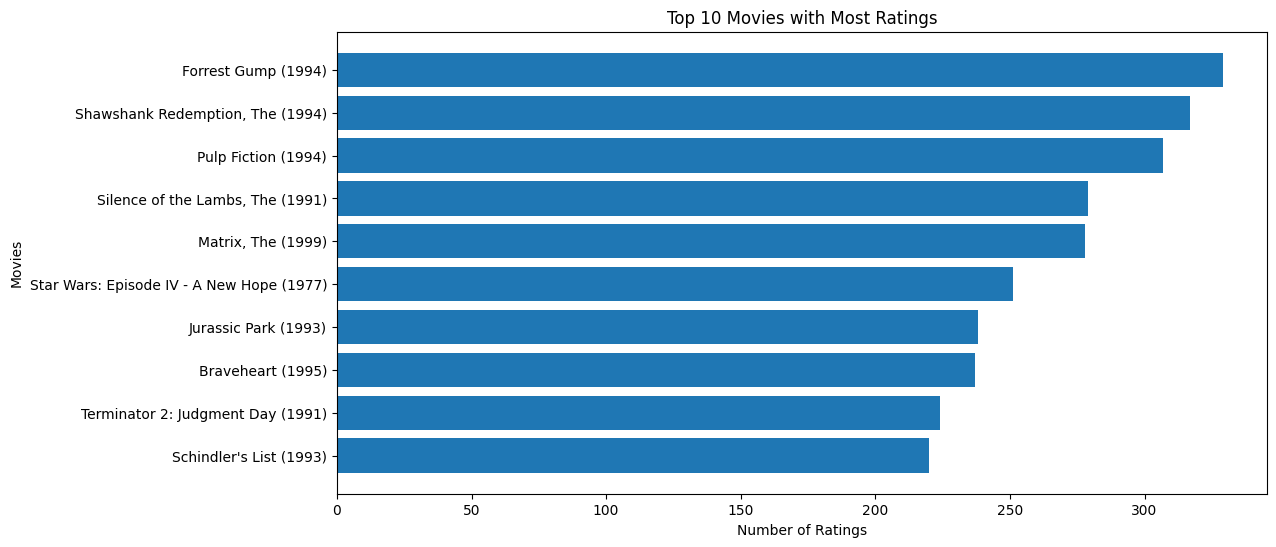

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming interactions_df is your dataset with at least 'item_id' and 'rating'.
# Let's also assume that movies_df is your dataset with at least 'item_id' and 'title'.

# Step 1: Aggregate the ratings
ratings_count = ratings_df.groupby('item_id')['rating'].count().reset_index(name='rating_count')

# Step 2: Merge the movie titles
ratings_with_titles = ratings_count.merge(movies_df[['item_id', 'title']], on='item_id')

# Step 3: Sort the data
sorted_ratings = ratings_with_titles.sort_values(by='rating_count', ascending=False)

# Step 4: Visualization
plt.figure(figsize=(12, 6))
plt.barh(sorted_ratings['title'][:10], sorted_ratings['rating_count'][:10])
plt.xlabel('Number of Ratings')
plt.ylabel('Movies')
plt.title('Top 10 Movies with Most Ratings')
plt.gca().invert_yaxis()  # To display the highest value on top
plt.show()

## Small preprocess

We first transform the columns in the table `ratings_df` to *int32*, as the recommender model needs this adaptation

In [9]:
ratings_df['user_id']=ratings_df['user_id'].astype('int32')
ratings_df['item_id']=ratings_df['item_id'].astype('int32')
ratings_df['timestamp']=ratings_df['timestamp'].astype('int32') #It is required by the model

We split the title of the movies in the `movies_df`, creating another column for the year of the film.

After that, we will get rid of the characters ', The', which are at the last part of some titles.

In [10]:
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4}(?:–\d{4})?)\)')  # Extracting the year or year range into a new column
movies_df['year'] = movies_df['year'].where(movies_df['year'].str.len() == 4, None)  # Set to None if not a single year
movies_df['title'] = movies_df['title'].str.replace(r'\(\d{4}(?:–\d{4})?\)', '', regex=True).str.strip()  # Removing the year from the title

movies_df['title']=movies_df['title'].str.replace(', The', '')
movies_df['genres']=movies_df['genres'].str.replace('|',', ')

In [11]:
from imdb import IMDb

na_rows = movies_df['year'].isna()

ia = IMDb()

def get_movie_year(title):
    try:
        movie = ia.search_movie(title)[0]
        return movie['year']
    except Exception as e:
        print(f"Error fetching year for '{title}': {e}")
        return None

# Apply the function to the dataframe
movies_df.loc[na_rows,'year'] = movies_df.loc[na_rows,'title'].apply(get_movie_year)

movies_df['year'] = movies_df['year'].astype(int)
print(movies_df)

      item_id                               title  \
0           1                           Toy Story   
1           2                             Jumanji   
2           3                    Grumpier Old Men   
3           4                   Waiting to Exhale   
4           5         Father of the Bride Part II   
...       ...                                 ...   
9737   193581  Black Butler: Book of the Atlantic   
9738   193583               No Game No Life: Zero   
9739   193585                               Flint   
9740   193587        Bungo Stray Dogs: Dead Apple   
9741   193609        Andrew Dice Clay: Dice Rules   

                                               genres  year  
0     Adventure, Animation, Children, Comedy, Fantasy  1995  
1                        Adventure, Children, Fantasy  1995  
2                                     Comedy, Romance  1995  
3                              Comedy, Drama, Romance  1995  
4                                              Comedy

## Implementing the recommender

Here's a brief explanation of some common hyperparameters for factorization models and a suggested grid for searching:

1. **n_iter**: The number of epochs to run when training the model. More epochs could lead to better performance but also increase the risk of overfitting and computational time.
   - Suggested grid: `[1, 5, 10, 20]`

2. **embedding_dim**: The size of the latent feature vectors for users and items. Larger dimensions could capture more complex patterns but might overfit.
   - Suggested grid: `[8, 16, 32, 64]`

3. **learning_rate**: The step size at each iteration of the optimization algorithm. A smaller learning rate could lead to more precise convergence but might require more epochs.
   - Suggested grid: `[0.001, 0.01, 0.1]`

4. **l2**: The L2 regularization penalty. Higher values could prevent overfitting but might lead to underfitting if too large.
   - Suggested grid: `[0.0, 1e-6, 1e-5, 1e-3]`

5. **loss**: The loss function to be used. Common options are `pointwise`, `bpr`, or `hinge` loss, which are suitable for different types of recommendation tasks.
   - Suggested values: `['pointwise', 'bpr', 'hinge']`

6. **batch_size**: The number of samples per gradient update. Larger batches provide more accurate estimates of the gradient, but smaller batches might help the model to generalize better.
   - Suggested grid: `[32, 64, 128, 256]`


### Training the model

In [12]:
from spotlight.interactions import Interactions
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.cross_validation import random_train_test_split


In [15]:
from spotlight.interactions import Interactions
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.cross_validation import random_train_test_split

# Step 2: Create the Interactions object
interaction_data = Interactions(
    user_ids=ratings_df['user_id'].values,
    item_ids=ratings_df['item_id'].values,
    ratings=ratings_df['rating'].values,
    timestamps=ratings_df['timestamp'].values
)

# Split the interaction data into training and test sets
train, test = random_train_test_split(interaction_data)

In [13]:
# Initialize the model
model = ExplicitFactorizationModel(
    n_iter=5,           # Number of epochs of training
    embedding_dim=32,   # Latent factors (embedding size)
    use_cuda=False      # If you have a CUDA capable GPU, set to True to speed up training
)

# Fit the model on the training data
model.fit(train, verbose=True)

Epoch 0: loss 4.224672758922054
Epoch 1: loss 0.8089573565501373
Epoch 2: loss 0.5204820127232128
Epoch 3: loss 0.37216186661901923
Epoch 4: loss 0.29550251624730794


In [13]:
from joblib import dump, load

#dump(model, 'model.pkl')

model = load('model.pkl')


In [16]:
from spotlight.evaluation import rmse_score

train_rmse = rmse_score(model, train)
test_rmse = rmse_score(model, test)

print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))

Train RMSE 0.629, test RMSE 0.631


### R1: Community recommender

Given a tag, a list of popular tags and a number of films (n), it returns the most *n* recommended films (ordered by rating) in the tag provided.

If the tag is not in the popular tags list, it returns an error.

In [14]:
# We first filter popular tags, which have more than 15 users
counter_tag= tags_df['tag'].value_counts()
popular_tag = counter_tag[counter_tag > 15]
popular_tag.head()

tag
In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
funny                 23
Name: count, dtype: int64

In [15]:
def community_recommender(tag, popular_tag, n, genre=None):
    popular_tag = [t.lower() for t in popular_tag.index] 
    tag = tag.lower()  # convert everything to lower case
    if tag in popular_tag:
        movie_filtered_by_tag = tags_df[tags_df['tag'].str.lower() == tag]
        movie_list = movie_filtered_by_tag['item_id']  # we extract here the movies that have this tag
        movies_filtered = ratings_df[ratings_df['item_id'].isin(movie_list)].groupby(['item_id'])['rating'].mean().reset_index()  # here we focus on those movies and then we extract the mean rating.
        
        # If genre filtering is enabled, filter the movies_df first
        if genre:
            movies_df_filtered_by_genre = movies_df[movies_df['genres'].str.contains(genre, case=False, na=False)]
            movies_filtered = movies_filtered[movies_filtered['item_id'].isin(movies_df_filtered_by_genre['item_id'])]
        
        movies_filtered.sort_values(by='rating', ascending=False, inplace=True)  # we sort them 
        top_movie_ids = movies_filtered.head(n)['item_id']  # here we extract the first n movies
        recommended_movies = movies_df[movies_df['item_id'].isin(top_movie_ids)]['title'].values.tolist()  # we extract the movies with that id
        return recommended_movies
    else:
        return 'No matches based on your research'

In [16]:
print("\n".join(community_recommender('suspense',popular_tag,10, genre='Comedy'))) #Example of how to use it.

Pulp Fiction


### R2: Rating prediction given a user and a movie

Given a user_id and a movie_title, it predicts the rating for the given movie and user.

In [17]:
def predict_rating_for_user_and_movie(model, user_id, movie_title, movies_df):
    # Predict scores for all items for the user
    pred = model.predict(user_ids=np.array([user_id]))

    # Get the movie indices sorted by predicted rating
    sorted_indices = np.argsort(pred)[::-1]

    # Find the movie ID corresponding to the given movie title
    movie_row = movies_df[movies_df['title'] == movie_title]
    if movie_row.empty:
        return "Movie title not found."

    movie_id = movie_row['item_id'].iloc[0]

    # Get the sorted index for this movie ID
    sorted_index = np.where(sorted_indices == movie_id)[0][0]

    # Get the predicted rating for the movie
    predicted_rating = pred[sorted_indices[sorted_index]]

    return predicted_rating

# Example usage
user_id = 10  # replace with the user ID
movie_title = "Ice Age 4: Continental Drift"  # replace with the movie title
predicted_rating = predict_rating_for_user_and_movie(model, user_id, movie_title, movies_df)
print(f"Predicted rating for user {user_id} and movie '{movie_title}': {predicted_rating}")

Predicted rating for user 10 and movie 'Ice Age 4: Continental Drift': 4.538609504699707


### R3: N recommended movies given a user

Given a user_id and number of recommendations (n), it returns the *n* recommended movies for that user.
We also filter by year and genre

In [17]:
def recommended_movies_by_user(model, user_id, n_movies, movies_df, genres=None, start_year=None, end_year=None):
    # Apply genre/year filters before making predictions
    if genres is not None:
        filter_condition = lambda x: any(genre.lower() in x.lower() for genre in genres)
        movies_df = movies_df[movies_df['genres'].apply(filter_condition)]
    if start_year is not None:
        if end_year is not None:
            movies_df = movies_df[(movies_df['year'] >= start_year) & (movies_df['year'] <= end_year)]
        else:
            movies_df = movies_df[movies_df['year'] >= start_year]

    # Now predict scores for the (optionally) filtered items for the user
    filtered_movie_ids = movies_df['item_id'].values
    pred = model.predict(user_ids=np.array([user_id]*len(filtered_movie_ids)), item_ids=filtered_movie_ids)

    # Sort predicted ratings in descending order
    sorted_indices = np.argsort(pred)[::-1]
    # Select the top n_movies
    top_indices = sorted_indices[:n_movies]
    recommended_movies = movies_df.iloc[top_indices]['title'].tolist()
    predicted_ratings = pred[top_indices]
    
    return recommended_movies, predicted_ratings

We have the following unique genres

In [18]:
# Splitting and exploding the genres column
all_genres = movies_df['genres'].str.split(', ').explode()

# Finding unique genres
unique_genres = all_genres.unique()

print(unique_genres)

['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'War' 'Musical'
 'Documentary' 'IMAX' 'Western' 'Film-Noir' '(no genres listed)']


In [19]:
min_year=movies_df['year'].min()
max_year=movies_df['year'].max()
print(min_year,max_year)

1902 2018


In [30]:
recommended_movies_by_user(model=model, user_id=299, n_movies=4, movies_df=movies_df, genres=['War'])

(["Kelly's Heroes", 'Doctor Zhivago', 'Paths of Glory', 'Tora! Tora! Tora!'],
 array([5.6826563, 5.4139657, 5.326546 , 5.3056893], dtype=float32))

In [31]:
titles_to_localize=["Kelly's Heroes", 'Doctor Zhivago', 'Paths of Glory', 'Tora! Tora! Tora!']
movies_df[movies_df['title'].isin(titles_to_localize)]

,item_id,title,genres,year
883,1178,Paths of Glory,"Drama, War",1957
1532,2067,Doctor Zhivago,"Drama, Romance, War",1965
2313,3066,Tora! Tora! Tora!,"Action, Drama, War",1970
2868,3836,Kelly's Heroes,"Action, Comedy, War",1970


### R4: N recommended movies for unseen users

Given a list of movies the user has seen and like, it returns the *n* movies most recommended, similar to the movies the user pass.

For that, we need another model which takes as input a list of movies, rather than a user_id.

In [48]:
from spotlight.sequence.implicit import ImplicitSequenceModel
from spotlight.cross_validation import user_based_train_test_split

train, test = user_based_train_test_split(interaction_data)

train = train.to_sequence()
test = test.to_sequence()

# Step 4: Model Configuration
model_seq = ImplicitSequenceModel(
    n_iter=15,
    batch_size=64,
    learning_rate=0.1,
    l2=1e-6,
    representation='cnn',  # Using LSTM representation
    loss='bpr'
)

# Step 5: Training
model_seq.fit(train, verbose=True)

Epoch 0: loss 0.08801506367280967
Epoch 1: loss 0.04237236193192184
Epoch 2: loss 0.04170784299590982
Epoch 3: loss 0.046129557703222544
Epoch 4: loss 0.04904810875598201
Epoch 5: loss 0.05146565435356215
Epoch 6: loss 0.05245026066563183
Epoch 7: loss 0.05190651194381535
Epoch 8: loss 0.053742461438689916
Epoch 9: loss 0.0537084390066172
Epoch 10: loss 0.054589861485742984
Epoch 11: loss 0.051835467030567337
Epoch 12: loss 0.05128447659649795
Epoch 13: loss 0.05120281138478365
Epoch 14: loss 0.05192264824881589


In [49]:
#dump(model_seq, 'model_seq.pkl')

model_seq = load('model_seq.pkl')

In [103]:
def recommend_next_movies(model, list_of_movies, n_movies, movies_df, genres=None, start_year=None, end_year=None):
    
    indices_movies = movies_df[movies_df['title'].isin(list_of_movies)]['item_id'] #we store the indices of the movies in list of movies
    
    # Apply genre/year filters before making predictions
    if genres is not None:
        filter_condition = lambda x: any(genre.lower() in x.lower() for genre in genres)
        movies_df = movies_df[movies_df['genres'].apply(filter_condition)]
    if start_year is not None:
        if end_year is not None:
            movies_df = movies_df[(movies_df['year'] >= start_year) & (movies_df['year'] <= end_year)]
        else:
            movies_df = movies_df[movies_df['year'] >= start_year]
    
    #END OF FILTERING PART
    
    #perform the predictions
    item_ids = movies_df['item_id'].values.reshape(-1, 1)
    pred = model.predict(sequences=np.array(indices_movies), item_ids=item_ids)
    sorted_indices = np.argsort(pred)[::-1]
    top_indices = sorted_indices[:n_movies]
    
    recommended_movies = movies_df.iloc[top_indices]['title'].values
    
    return recommended_movies

In [51]:
test1 = ['Silence of the Lambs', 'World War Z', 'Exorcist']
test2 = ['Ice Age 4: Continental Drift', 'Toy Story', 'Jumanji', 'Monsters, Inc.']

indices_movies1 = movies_df[movies_df['title'].isin(test1)]['item_id']
indices_movies2 = movies_df[movies_df['title'].isin(test2)]['item_id']
item_ids = movies_df['item_id'].values.reshape(-1, 1)

# Le seguenti righe calcolano le previsioni, ma potrebbero non essere necessarie per la tua logica attuale
pred1 = model_seq.predict(sequences=np.array(indices_movies1), item_ids=item_ids)
pred2 = model_seq.predict(sequences=np.array(indices_movies2), item_ids=item_ids)

# Se non hai intenzione di utilizzare pred1 e pred2, puoi eliminarle

print(recommend_next_movies(model_seq, test1, n_movies=10, movies_df=movies_df))
print(recommend_next_movies(model_seq, test2, n_movies=10, movies_df=movies_df))


['Sherlock Holmes' 'Indiana Jones and the Last Crusade'
 'City of God (Cidade de Deus)' 'Gone in 60 Seconds' 'Captain Ron'
 'Babe: Pig in the City' 'Starship Troopers 2: Hero of the Federation'
 'My Love' 'Sandpiper' 'Godzilla']
['Sherlock Holmes' 'Inherit the Wind' 'Indiana Jones and the Last Crusade'
 'Babe: Pig in the City' 'Kill Bill: Vol. 1'
 'Independence Day (a.k.a. ID4)' 'Godzilla' "My Best Friend's Wedding"
 "Class of Nuke 'Em High" 'Kinky Boots']


In [104]:
recommend_next_movies(model_seq, ['Scream'], n_movies=5, movies_df=movies_df, genres=['Animation'])

array(['Batman vs. Robin', 'My Love', 'Frozen', "Bug's Life, A",
       'Team America: World Police'], dtype=object)

In [105]:
titles_to_localize=['Batman vs. Robin', 'My Love', 'Frozen', "Bug's Life, A",
       'Team America: World Police']
movies_df[movies_df['title'].isin(titles_to_localize)]

,item_id,title,genres,year
1757,2355,"Bug's Life, A","Adventure, Animation, Children, Comedy",1998
5350,8917,Team America: World Police,"Action, Adventure, Animation, Comedy",2004
7288,75395,Frozen,"Drama, Horror, Thriller",2010
8303,106696,Frozen,"Adventure, Animation, Comedy, Fantasy, Musical...",2013
8829,131739,Batman vs. Robin,"Action, Adventure, Animation",2015
8877,134095,My Love,"Animation, Drama",2006


In [66]:
genres=['Horror']
filter_condition = lambda x: any(genre.lower() in x.lower() for genre in genres)
test_df = movies_df[movies_df['genres'].apply(filter_condition)]

### IDEA ON HOW TO INCLUDE THE FEEDBACK BASED ON THE STAR FEEDBACK. 

The idea is that the vector of prediction is somehow weighted by the star feedback, in order to do so we just apply a vector multiplication (component by component) in this way:

$$ [p_1, \ldots, p_n] \cdot [w_1, \ldots, w_n] = [p_1 \cdot w_1, \ldots, p_n \cdot w_n] $$
where $p_i$ are the predictions and $w_i$ the weights. 

Then, what we do is just create a user-based weights vector initialized as $1$ and then once we have a feedback for a specific movie we just change the weight referred to that movie. For example, if we have $2$ stars feedback for movie $1$ then $w_1=2/5$. The general form of the weight can be 
$$ w=\frac{\text{n° of stars out of 5}}{5} $$

First version of the code: it can be modified to get better computational time and memory storage

In [ ]:
unique_movies = movies_df['item_id'].nunique()
unique_users= ratings_df['user_id'].nunique()

W_matrix=np.ones((unique_movies,unique_users)) #weight matrix

#let's create the function that change the weights according to the star feedback

def update_weights(user_id,list_titles,feedbacks,W_matrix):
    i=0
    #titles contains the list of titles that has a feedback, while feedbacks is a vector that is of the form [4/5,5/5,1/5,...]
    for title in list_titles:
        index=movies_df.index[movies_df['title']==title] 
        W_matrix[index,user_id]=feedbacks[i]
        i+=
    return W_matrix

#now if we want to implement this we just have to perform the following in R3:
#pred = model.predict(user_ids=np.array([user_id]*len(filtered_movie_ids)), item_ids=filtered_movie_ids)
#pred=pred*W_matrix[:,user_id] and we have the weighted prediction